# Lab Assignment Six: Convolutional Network Architectures

***Md Mahfuzur Rahman, Will Schneider, Nik Zelenikovski***


In [145]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

#Read in images as numpy arrays
#Following code adapted from Kazan, F. (2022). Animals [Code]. Retrieved from https://www.kaggle.com/code/furkankazan/animals
!pip install opencv-python
import cv2
from PIL import Image

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf

print('Tensorflow version:',tf.__version__)

tf.random.set_seed(2)
np.random.seed(0) # using this to help make results more reproducible
tf.config.list_physical_devices('GPU')

# Directory containing the dataset
data_dir ='/content/drive/MyDrive/animals/animals'

# Define image size
image_size = (64, 64)  # Example size, can be adjusted

## UNCOMMENT THIS CODE WHEN FIRST IMPORTING DATA##
## THEN PULL AS AN ARRAY FOR SESSIONS AFTER##
# # Initialize lists to store image data and labels
# images = []
# labels = []

# # Read images and labels
# for animal_class in os.listdir(data_dir):
#     animal_dir = os.path.join(data_dir, animal_class)
#     if os.path.isdir(animal_dir):
#         for image_name in os.listdir(animal_dir):
#             image_path = os.path.join(animal_dir, image_name)
#             print(image_path)
#             image = Image.open(image_path)
#             image = image.resize(image_size).convert('RGB')
#             images.append(np.array(image))
#             labels.append(animal_class)

# # Convert lists to numpy arrays
# images = np.array(images)
# labels = np.array(labels)


# # Path to the directory in your Google Drive where you want to save the array
# save_path = '/content/drive/My Drive/array.npz'

# # Save multiple arrays to a file
# np.savez(save_path, array1=images, array2=labels)

# # Verify the file was saved
# print(f"Array saved to {save_path}")

# Load arrays from the file
loaded_arrays = np.load('/content/drive/My Drive/array.npz')
images = loaded_arrays['array1']
labels = loaded_arrays['array2']

Tensorflow version: 2.15.0


### Preparation

### Evaluating Model Performance in Animal Identification for Feedlot Management - F1 Score

When it comes to identifying different animal types from images in a feedlot or ranching scenario, selecting the right evaluation metrics is crucial. Precision and recall, along with their harmonic mean, the **F1 Score**, provide a comprehensive picture of a model's performance, ensuring effective resource management and animal care.

**Precision** measures how accurate the model's positive predictions are. In our context, this means precision shows how often the model correctly identifies a specific animal type when it makes a prediction. High precision is essential in a feedlot or ranch because it ensures that when the model predicts a certain animal type, such as cattle, it is likely correct. This accuracy is vital for resource allocation, precise inventory management, and overall cost efficiency, as it minimizes the misallocation of resources intended for different animal types.

**Recall** measures the model's ability to identify all instances of a specific animal type in the dataset. High recall ensures that the model captures as many instances of each animal type as possible, such as all sheep in a dataset of 100 sheep images. This comprehensive identification is crucial for thorough tracking and management, ensuring that no animal is overlooked and all receive the necessary care and resources.

The **F1 Score**, which combines precision and recall into a single metric, is our primary accuracy measure. The F1 score provides a balanced assessment of the model's performance by calculating the harmonic mean of precision and recall. This metric is particularly valuable when both false positives and false negatives carry significant consequences. It ensures that the model not only accurately identifies animals but also captures as many instances as possible, giving a holistic view of its effectiveness.

In summary, we opted for the **F1 score** as our primary metric because it offers a balanced and comprehensive measure of the model's performance. By ensuring both high precision and recall, the F1 score supports effective decision-making in resource management and animal care within feedlot or ranching operations. This approach guarantees that the model is reliable and robust, capable of accurately identifying various animal types while capturing all necessary instances, thus optimizing the overall management of the feedlot.

### Choosing the Right Data Splitting Method for Training and Testing



In [91]:
print('Tensorflow version:',tf.__version__)

Tensorflow version: 2.15.0


In [146]:
# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

For our machine learning model tasked with identifying animal types in a feedlot management scenario, we opted for a **single train-test split**. This decision was influenced by several key factors that make this approach both practical and effective for our specific needs.

When training models with large datasets and multiple epochs, a single train-test split is computationally efficient and allows resources to be focused on training. It's also more straightforward than using methods like k-fold cross-validation, making it easier to iterate and improve the model. In real-world scenarios, models are often trained once and deployed, making a single train-test split a practical choice for assessing model performance. With a well-chosen split, the training and testing sets can effectively represent the data distribution, ensuring reliable performance metrics.

(4312, 64, 64, 3)


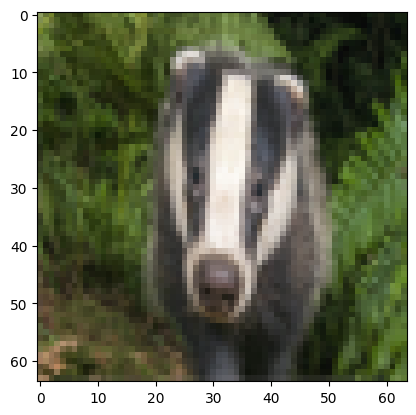

'badger'

In [148]:
#Check picture to ensure correct data importation
print(X_train.shape)
plt.subplot(1,1,1)
plt.imshow(X_train[1].squeeze(),cmap='bone')
plt.show()

y_train[1]

## Modeling

### Data Expansion / Data Augmentation in Keras

Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You should make use of Keras augmentation layers, like in the class examples.

In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomBrightness, RandomContrast, RandomZoom

# Define a function to create data augmentation layers
def add_data_augmentation_layers(model):
    model.add(RandomFlip("horizontal"))
    model.add(RandomRotation(0.05))
    #model.add(RandomTranslation(height_factor = 0.1, width_factor = 0.1))
    #model.add(RandomBrightness(factor=0.1, value_range=(0.0,1.0)))
    #model.add(RandomContrast(0.1))
    model.add(RandomZoom(0.1))

# # Add rescaling layer
# normalization_layer = Rescaling(1./255)

### CNN Architecture 1

#### Parameters 1

In [149]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras
print(tf.__version__)

# CREATE A CNN WITH ONLY ONE CONVOLUTIONAL LAYER AND ONE OUTPUT LAYER

# since this is not binary, we should go ahead and one-hot encode the inputs
# Convert string labels to integer labels
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_test_int = le.transform(y_test)
NUM_CLASSES = len(np.unique(labels))
IMG_DIM = len(X_train[0][0][:])

#NORMALIZE THE DATA
# Assuming X_train and X_test are your image datasets with shape (samples, height, width, channels)
original_shape = X_train.shape

# Reshape the data to 2D (samples, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], -1))
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))

# Standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_reshaped)
X_test_std = scaler.transform(X_test_reshaped)

# Reshape the data back to the original shape
X_train_std = X_train_std.reshape(original_shape)
X_test_std = X_test_std.reshape(X_test.shape[0], original_shape[1], original_shape[2], original_shape[3])

# One-hot encode the integer labels
y_train_ohe = to_categorical(y_train_int,NUM_CLASSES)
y_test_ohe = to_categorical(y_test_int, NUM_CLASSES)

2.15.0


In [150]:
# %%time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, F1Score


# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# make a CNN with conv layer and max pooling
cnn1 = Sequential(name='one_layer')
add_data_augmentation_layers(cnn1)
cnn1.add( Conv2D(filters=16,
                 kernel_size= (2, 2),
                 padding='same'))

cnn1.add(Conv2D(filters=32,
                kernel_size=(3,3),
                padding='same')) # more compact syntax

cnn1.add( MaxPooling2D(pool_size=(2, 2)))
cnn1.add( Activation('relu'))
# add one layer on flattened output
cnn1.add( Flatten() )
cnn1.add(Dense(NUM_CLASSES))
cnn1.add( Activation('softmax') )

# the shape of input (batch x h x w x channels)
print(X_train.shape)

# Let's train the model
cnn1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','F1Score'])

history1 = cnn1.fit(X_train_std, y_train_ohe, batch_size=64, epochs=75,
                    shuffle=True, verbose=0,
                    validation_data=(X_test_std,y_test_ohe),callbacks=[early_stopping])

print(cnn1.summary())

(4312, 64, 64, 3)
Model: "one_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_28 (RandomFlip  (None, 64, 64, 3)         0         
 )                                                               
                                                                 
 random_rotation_28 (Random  (None, 64, 64, 3)         0         
 Rotation)                                                       
                                                                 
 random_zoom_28 (RandomZoom  (None, 64, 64, 3)         0         
 )                                                               
                                                                 
 conv2d_74 (Conv2D)          (None, 64, 64, 16)        208       
                                                                 
 conv2d_75 (Conv2D)          (None, 64, 64, 32)        4640      
                                       

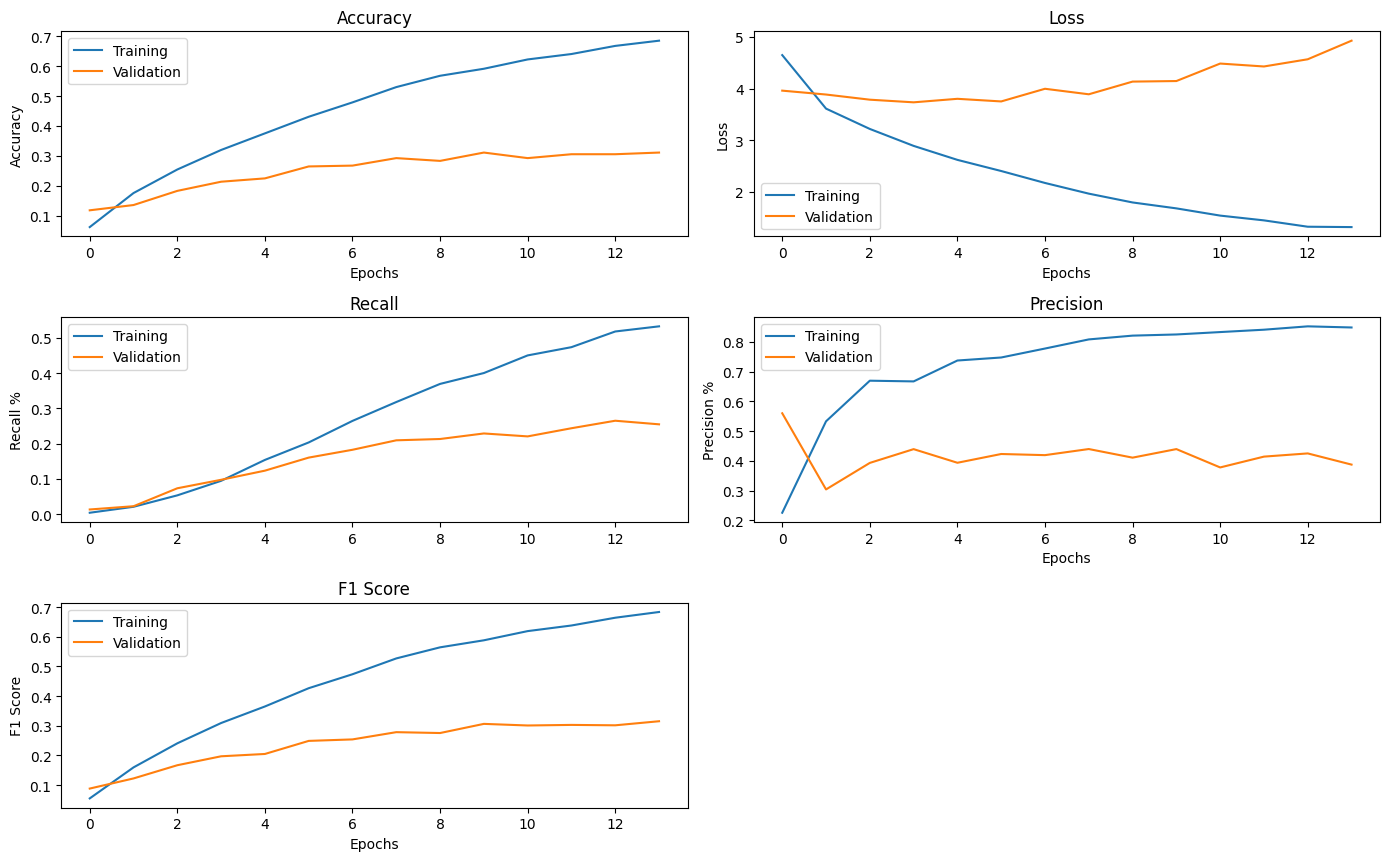

In [151]:
# Set the figure size to make the subplots larger
plt.figure(figsize=(14, 14))

# Accuracy Plot
plt.subplot(5,2,1)
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(5,2,2)
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()

# Recall Plot
plt.subplot(5,2,3)
plt.plot(history1.history['recall'], label='Training')
plt.plot(history1.history['val_recall'], label='Validation')
plt.ylabel('Recall %')
plt.title('Recall')
plt.legend()

# Precision Plot
plt.subplot(5,2,4)
plt.plot(history1.history['precision'], label='Training')
plt.plot(history1.history['val_precision'], label='Validation')
plt.ylabel('Precision %')
plt.xlabel('Epochs')
plt.title('Precision')
plt.legend()

f1s_1 = [np.mean(history1.history['f1_score'][i]) for i in range(len(history1.history['f1_score']))]
val_f1s_1 = [np.mean(history1.history['val_f1_score'][i]) for i in range(len(history1.history['f1_score']))]

# F1 Score Plot
plt.subplot(5,2,5)
plt.plot(f1s_1, label='Training')
plt.plot(val_f1s_1, label='Validation')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

#### Parameters 2

##### Changes:
  1. **Increased Kernel Size:**
  From 2x2 to 3x3: Larger kernels can capture more spatial context from the input images, potentially improving feature extraction.

  2. **Increased Number of Filters:**
   From 16 to 32 and from 32 to 64: Increasing the number of filters allows the network to learn more complex patterns and features from the images, potentially enhancing the model's performance.

  3. **Modified Strides:**
  From 1 to 2: The stride specifies the number of pixels by which the filter shifts over the input. By increasing the stride to (2, 2), the filter moves two pixels at a time both horizontally and vertically. This reduces the spatial dimensions of the output, similar to the effect of max pooling, but achieved through convolutional layers. The change in strides, combined with the increase in filter numbers, is expected to impact how well the model extracts and generalizes features.

  4. **Increased Batch Size:**
  From 64 to 128: Larger batch sizes can lead to more stable gradient estimates and can leverage GPU parallelism better, potentially speeding up the training process.

In [152]:
%%time

# changes:
#    1. increased the kernel size of the filters
#    2. increased the number of filters from 32 to 64
#    3. increase the number of horizontal and vertical strides to 2
# make a CNN with conv layer and max pooling
cnn2 = Sequential(name='one_layer_v2')
add_data_augmentation_layers(cnn2)
cnn2.add( Conv2D(filters=64,
                 strides=(2,2),
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu') #,
                # input_shape=(IMG_DIM, IMG_DIM, 3),
               )

cnn2.add(Conv2D(filters=64,
                kernel_size= (3, 3),
                padding='same',
                activation='relu')) # more compact syntax

cnn2.add( MaxPooling2D(pool_size=(2, 2)) )
cnn2.add( Activation('relu') )
# add one layer on flattened output
cnn2.add( Flatten() )
cnn2.add( Dense(NUM_CLASSES) )
cnn2.add( Activation('softmax') )

# Let's train the model
cnn2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','F1Score'])

history2 = cnn2.fit(X_train_std, y_train_ohe,
                    batch_size=128, epochs=75,
                    shuffle=True, verbose=0,
                    validation_data=(X_test_std,y_test_ohe),callbacks = [early_stopping])

print(cnn2.summary())

Model: "one_layer_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_29 (RandomFlip  (None, 64, 64, 3)         0         
 )                                                               
                                                                 
 random_rotation_29 (Random  (None, 64, 64, 3)         0         
 Rotation)                                                       
                                                                 
 random_zoom_29 (RandomZoom  (None, 64, 64, 3)         0         
 )                                                               
                                                                 
 conv2d_76 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_77 (Conv2D)          (None, 32, 32, 64)        36928     
                                                      

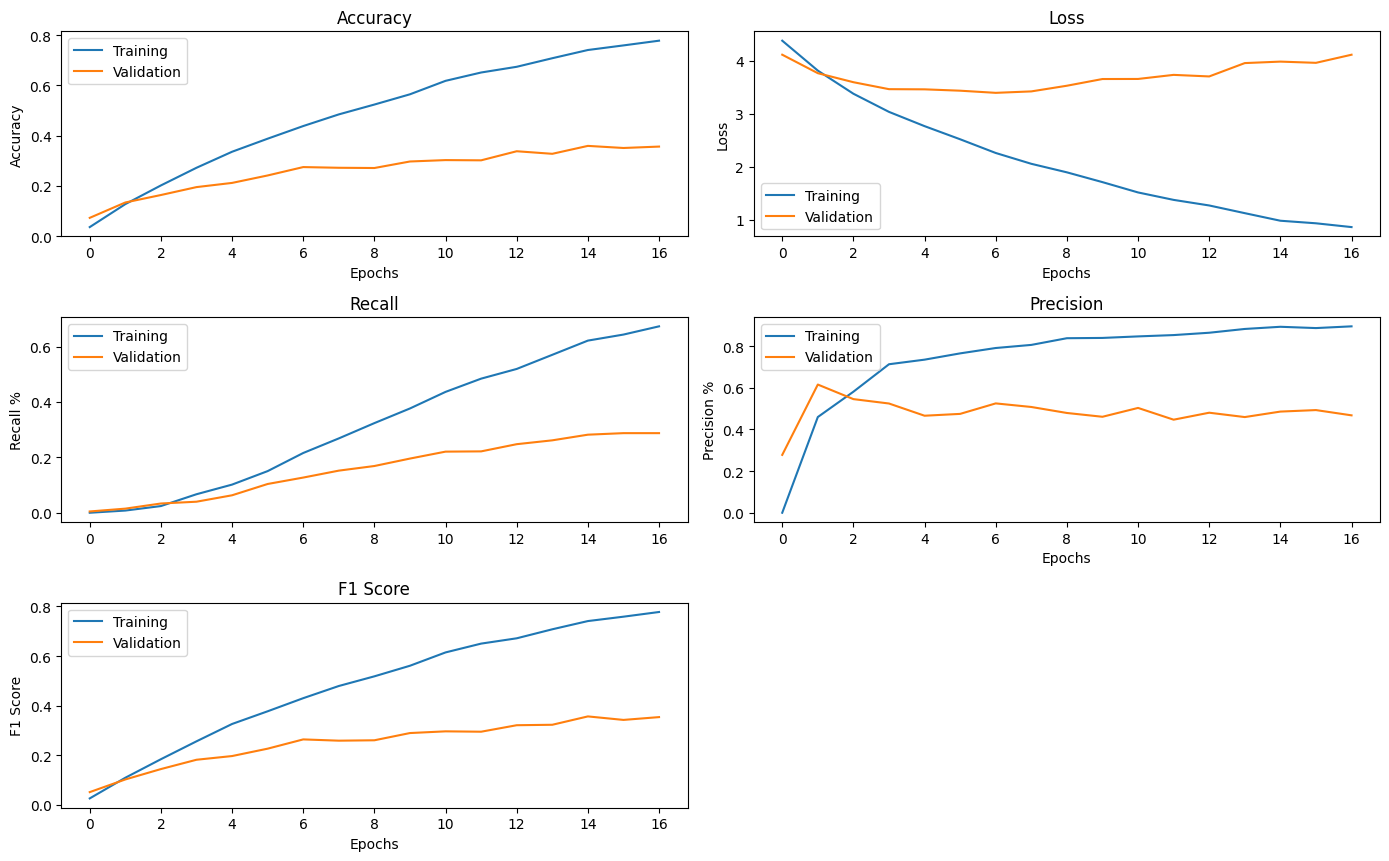

In [153]:
# Set the figure size to make the subplots larger
plt.figure(figsize=(14, 14))

# Accuracy Plot
plt.subplot(5,2,1)
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(5,2,2)
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()

# Recall Plot
plt.subplot(5,2,3)
plt.plot(history2.history['recall'], label='Training')
plt.plot(history2.history['val_recall'], label='Validation')
plt.ylabel('Recall %')
plt.title('Recall')
plt.legend()

# Precision Plot
plt.subplot(5,2,4)
plt.plot(history2.history['precision'], label='Training')
plt.plot(history2.history['val_precision'], label='Validation')
plt.ylabel('Precision %')
plt.xlabel('Epochs')
plt.title('Precision')
plt.legend()

f1s_2 = [np.mean(history2.history['f1_score'][i]) for i in range(len(history2.history['f1_score']))]
val_f1s_2 = [np.mean(history2.history['val_f1_score'][i]) for i in range(len(history2.history['f1_score']))]

# F1 Score Plot
plt.subplot(5,2,5)
plt.plot(f1s_2, label='Training')
plt.plot(val_f1s_2, label='Validation')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

### CNN Architecture 2


#### Parameters 1

In [154]:
%%time

cnn3 = Sequential(name='two_layer')
add_data_augmentation_layers(cnn3)
# let's start with an AlexNet style convolutional phase
cnn3.add(Conv2D(filters=16,
                kernel_size= (2, 2),
                padding='same',
                activation='relu',
                data_format="channels_last"))

# no max pool before next conv layer!!
cnn3.add(Conv2D(filters=32,
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format="channels_last")) # more compact syntax
cnn3.add(MaxPooling2D(pool_size=(2, 2)))

cnn3.add(Conv2D(filters=64,
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format="channels_last"))# more compact syntax

cnn3.add(MaxPooling2D(pool_size=(2, 2)))
# add one layer on flattened output
cnn3.add(Dropout(0.3)) # add some dropout for regularization after conv layers
cnn3.add(Flatten())
cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn3.add(Dense(NUM_CLASSES, activation='softmax')) #Added

# Let's train the model
cnn3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','F1Score'])


# the flow method yields batches of images indefinitely, with the given transformations
history3 = cnn3.fit(X_train_std, y_train_ohe,
                   batch_size=32, shuffle = True,
                   epochs=125, verbose=0,
                   validation_data=(X_test_std,y_test_ohe),callbacks=[early_stopping])

cnn3.summary()

Model: "two_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_30 (RandomFlip  (None, 64, 64, 3)         0         
 )                                                               
                                                                 
 random_rotation_30 (Random  (None, 64, 64, 3)         0         
 Rotation)                                                       
                                                                 
 random_zoom_30 (RandomZoom  (None, 64, 64, 3)         0         
 )                                                               
                                                                 
 conv2d_78 (Conv2D)          (None, 64, 64, 16)        208       
                                                                 
 conv2d_79 (Conv2D)          (None, 64, 64, 32)        4640      
                                                         

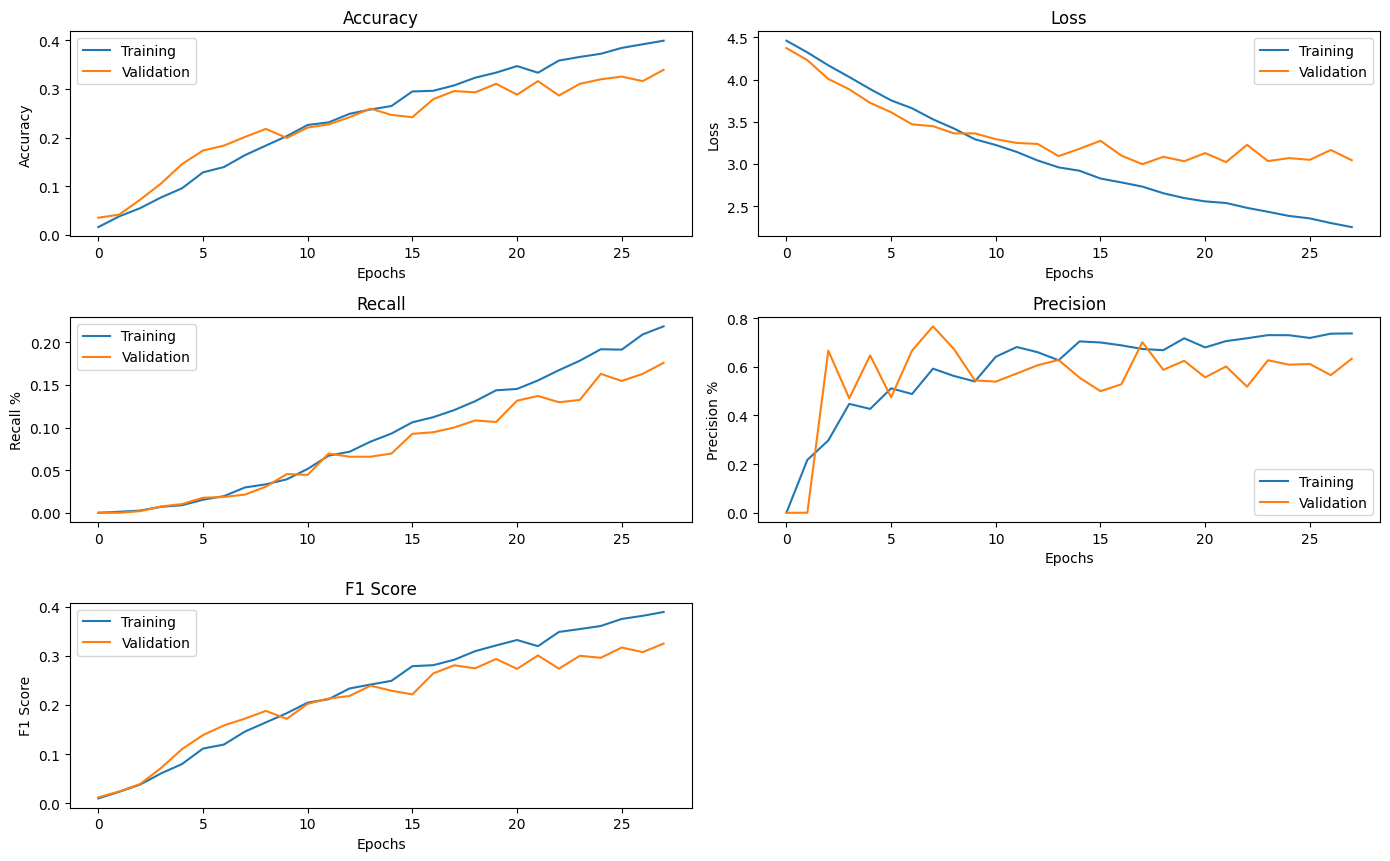

In [155]:
# Set the figure size to make the subplots larger
plt.figure(figsize=(14, 14))

# Accuracy Plot
plt.subplot(5,2,1)
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(5,2,2)
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()

# Recall Plot
plt.subplot(5,2,3)
plt.plot(history3.history['recall'], label='Training')
plt.plot(history3.history['val_recall'], label='Validation')
plt.ylabel('Recall %')
plt.title('Recall')
plt.legend()

# Precision Plot
plt.subplot(5,2,4)
plt.plot(history3.history['precision'], label='Training')
plt.plot(history3.history['val_precision'], label='Validation')
plt.ylabel('Precision %')
plt.xlabel('Epochs')
plt.title('Precision')
plt.legend()

f1s_3 = [np.mean(history3.history['f1_score'][i]) for i in range(len(history3.history['f1_score']))]
val_f1s_3 = [np.mean(history3.history['val_f1_score'][i]) for i in range(len(history3.history['f1_score']))]

# F1 Score Plot
plt.subplot(5,2,5)
plt.plot(f1s_3, label='Training')
plt.plot(val_f1s_3, label='Validation')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

#### Parameters 2



##### Changes:
**Filter Sizes:**

The number of filters has been increased to 32 in the first layer, 64 in the middle layer, and 64 in the last convolutional layer. This allows the network to accommodate more complex features and patterns in the input data, resulting in improved performance and accuracy

**Strides:**

A stride of 2 is applied in the last convolutional layer. Strides determine how much the filter moves over the input image. A stride of 2 reduces the spatial dimensions of the output, similar to max pooling, but achieved through the convolutional operation. This helps to downsample the feature maps, reducing computational load and focusing on more significant features.

**Kernel Sizes:**

The first layer uses a 2x2 kernel, while the subsequent layers use 3x3 kernels. Smaller kernels in the initial layer capture finer details, while larger kernels in later layers capture more spatial context, improving the network's ability to recognize patterns at different scales.

**Regularization:**

Regularization is applied to convolutional layers to prevent overfitting by penalizing large weights, encouraging the model to maintain smaller weights and promote generalization.

**Kernel Initializer:**

The Glorot Uniform initializer and L2 lambda kernel regularizers help balance weight initialization and regularization during training, improving model convergence.



In [156]:
%%time

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
l2_lambda = 0.0001


# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

cnn4 = Sequential(name='two_layer_v2')
add_data_augmentation_layers(cnn4)
# let's start with an AlexNet style convolutional phase
cnn4.add(Conv2D(filters=32,
                kernel_size= (3, 3),
                padding='same',
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                activation='relu'))
                # input_shape=(IMG_DIM, IMG_DIM, 3)))

cnn4.add(Conv2D(filters=64,
                kernel_size= (3, 3),
                padding='same',
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                activation='relu')) # more compact syntax

cnn4.add(MaxPooling2D(pool_size=(2, 2)))

cnn4.add(Conv2D(filters=64,
                kernel_size=(3,3),
                padding='same',
                kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda),
                activation='relu')) # more compact syntax

cnn4.add(MaxPooling2D(pool_size=(2, 2)))

# add one layer on flattened output
cnn4.add(Dropout(0.3)) # add some dropout for regularization after conv layers
cnn4.add(Flatten())
cnn4.add(Dense(128, activation='relu'))
cnn4.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn4.add(Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform', #Add glorot uniform and l2 lambda kernel regularizers.
              kernel_regularizer=l2(l2_lambda)))


# Let's train the model
cnn4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','F1Score'])


# the flow method yields batches of images indefinitely, with the given transformations
history4 = cnn4.fit(X_train_std, y_train_ohe, batch_size=32, shuffle=True,
                   epochs=125, verbose=1,
                   validation_data=(X_test_std,y_test_ohe),
                   callbacks = [early_stopping])


cnn4.summary()

Epoch 1/125
135/135 [==============================] - 6s 25ms/step - loss: 4.7006 - accuracy: 0.0077 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0028 - val_loss: 4.5388 - val_accuracy: 0.0111 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0046
Epoch 2/125
135/135 [==============================] - 3s 19ms/step - loss: 4.5294 - accuracy: 0.0153 - precision: 1.0000 - recall: 2.3191e-04 - f1_score: 0.0044 - val_loss: 4.5030 - val_accuracy: 0.0213 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0100
Epoch 3/125
135/135 [==============================] - 2s 17ms/step - loss: 4.4959 - accuracy: 0.0239 - precision: 0.3333 - recall: 2.3191e-04 - f1_score: 0.0124 - val_loss: 4.4322 - val_accuracy: 0.0315 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0114
Epoch 4/125
135/135 [==============================] - 2s 18ms/step - loss: 4.4178 - accuracy: 0.0278 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_scor

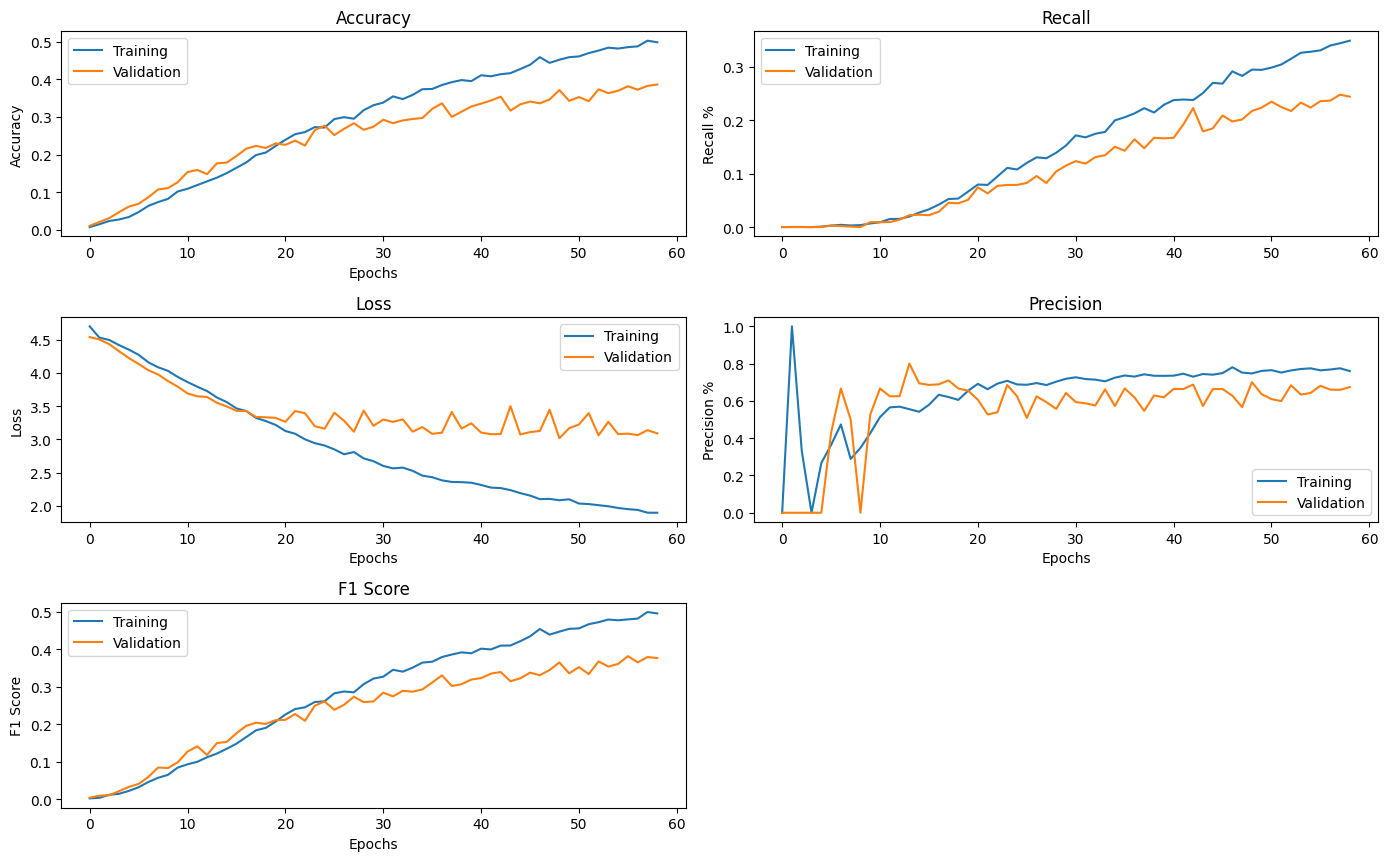

In [157]:
from matplotlib import pyplot as plt
# Set the figure size to make the subplots larger
plt.figure(figsize=(14, 14))

# Accuracy Plot
plt.subplot(5,2,1)
plt.plot(history4.history['accuracy'], label='Training')
plt.plot(history4.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.legend()

# Recall Plot
plt.subplot(5,2,2)
plt.plot(history4.history['recall'], label='Training')
plt.plot(history4.history['val_recall'], label='Validation')
plt.ylabel('Recall %')
plt.title('Recall')
plt.legend()

# Loss Plot
plt.subplot(5,2,3)
plt.plot(history4.history['loss'], label='Training')
plt.plot(history4.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()

# Precision Plot
plt.subplot(5,2,4)
plt.plot(history4.history['precision'], label='Training')
plt.plot(history4.history['val_precision'], label='Validation')
plt.ylabel('Precision %')
plt.xlabel('Epochs')
plt.title('Precision')
plt.legend()

f1s_4 = [np.mean(history4.history['f1_score'][i]) for i in range(len(history4.history['f1_score']))]
val_f1s_4 = [np.mean(history4.history['val_f1_score'][i]) for i in range(len(history4.history['f1_score']))]
# F1 Score Plot
plt.subplot(5,2,5)
plt.plot(f1s_4, label='Training')
plt.plot(val_f1s_4, label='Validation')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

###  Statistical comparison between CNN models

#### McNemar

In [158]:
X_train, X_test, y_train,  y_test = train_test_split(images, labels,
                                                     test_size = 0.2,
                                                     stratify=labels,
                                                     random_state=7324,
                                                     shuffle=True)

yhat_model1 = np.argmax(cnn1.predict(X_test_std), axis=1)
yhat_model2 = np.argmax(cnn2.predict(X_test_std), axis=1)
yhat_model3 = np.argmax(cnn3.predict(X_test_std), axis=1)
yhat_model4 = np.argmax(cnn4.predict(X_test_std), axis=1)

34/34 [==============================] - 0s 6ms/step


In [159]:
from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_table

print('The comparison between Model 1 and Model 2 with 95% confidence interval is as follows:')
table1 = mcnemar_table(y_target=y_test_int, y_model1=yhat_model1, y_model2=yhat_model2)
chi12_, p12 = mcnemar(ary=table1, corrected=True)
print(table1)
print(f"chi² statistic: {chi12_}, p-value: {p12}")
if p12 > 0.05:
    print("Same proportions of errors (failed to reject Null Hypothesis--There isn't enough evidence to suggest that Models 1 and 2 are different from each other )")
else:
        print('Different proportions of errors (reject Null Hypothesis)')

print("========================================================================================")

print('The comparison between Model 1 and Model 3 with 95% confidence interval is as follows:')
table2 = mcnemar_table(y_target=y_test_int, y_model1=yhat_model1, y_model2=yhat_model3)
chi12_, p12 = mcnemar(ary=table2, corrected=True)
print(table2)
print(f"chi² statistic: {chi12_}, p-value: {p12}")
if p12 > 0.05:
    print("Same proportions of errors (failed to reject Null Hypothesis--There isn't enough evidence to suggest that Models 1 and 3 are different from each other )")
else:
        print('Different proportions of errors (reject Null Hypothesis)')


print("========================================================================================")

print('The comparison between Model 1 and Model 4 with 95% confidence interval is as follows:')
table3 = mcnemar_table(y_target=y_test_int, y_model1=yhat_model1, y_model2=yhat_model4)
chi12_, p12 = mcnemar(ary=table3, corrected=True)
print(table3)
print(f"chi² statistic: {chi12_}, p-value: {p12}")
if p12 > 0.05:
    print("Same proportions of errors (failed to reject Null Hypothesis--There isn't enough evidence to suggest that Models 1 and 4 are different from each other )")
else:
        print('Different proportions of errors (reject Null Hypothesis)')


print("========================================================================================")

print('The comparison between Model 2 and Model 3 with 95% confidence interval is as follows:')
table4 = mcnemar_table(y_target=y_test_int, y_model1=yhat_model2, y_model2=yhat_model3)
chi12_, p12 = mcnemar(ary=table4, corrected=True)
print(table4)
print(f"chi² statistic: {chi12_}, p-value: {p12}")
if p12 > 0.05:
    print("Same proportions of errors (failed to reject Null Hypothesis--There isn't enough evidence to suggest that Models 2 and 3 are different from each other )")
else:
        print('Different proportions of errors (reject Null Hypothesis)')


print("========================================================================================")


print('The comparison between Model 2 and Model 4 with 95% confidence interval is as follows:')
table5 = mcnemar_table(y_target=y_test_int, y_model1=yhat_model2, y_model2=yhat_model4)
chi12_, p12 = mcnemar(ary=table5, corrected=True)
print(table5)
print(f"chi² statistic: {chi12_}, p-value: {p12}")
if p12 > 0.05:
    print("Same proportions of errors (failed to reject Null Hypothesis--There isn't enough evidence to suggest that Models 2 and 4 are different from each other )")
else:
        print('Different proportions of errors (reject Null Hypothesis)')


print("========================================================================================")
print('The comparison between Model 3 and Model 4 with 95% confidence interval is as follows:')
table6 = mcnemar_table(y_target=y_test_int, y_model1=yhat_model3, y_model2=yhat_model4)
chi12_, p12 = mcnemar(ary=table6, corrected=True)
print(table6)
print(f"chi² statistic: {chi12_}, p-value: {p12}")
if p12 > 0.05:
    print("Same proportions of errors (failed to reject Null Hypothesis--There isn't enough evidence to suggest that Models 3 and 4 are different from each other )")
else:
        print('Different proportions of errors (reject Null Hypothesis)')


print("========================================================================================")

The comparison between Model 1 and Model 2 with 95% confidence interval is as follows:
[[133  98]
 [164 684]]
chi² statistic: 16.125954198473284, p-value: 5.926624060536017e-05
Different proportions of errors (reject Null Hypothesis)
The comparison between Model 1 and Model 3 with 95% confidence interval is as follows:
[[144  87]
 [175 673]]
chi² statistic: 28.889312977099237, p-value: 7.663457418048795e-08
Different proportions of errors (reject Null Hypothesis)
The comparison between Model 1 and Model 4 with 95% confidence interval is as follows:
[[159  72]
 [242 606]]
chi² statistic: 90.95859872611464, p-value: 1.4670989635251156e-21
Different proportions of errors (reject Null Hypothesis)
The comparison between Model 2 and Model 3 with 95% confidence interval is as follows:
[[182 115]
 [137 645]]
chi² statistic: 1.75, p-value: 0.1858767323658721
Same proportions of errors (failed to reject Null Hypothesis--There isn't enough evidence to suggest that Models 2 and 3 are different fro

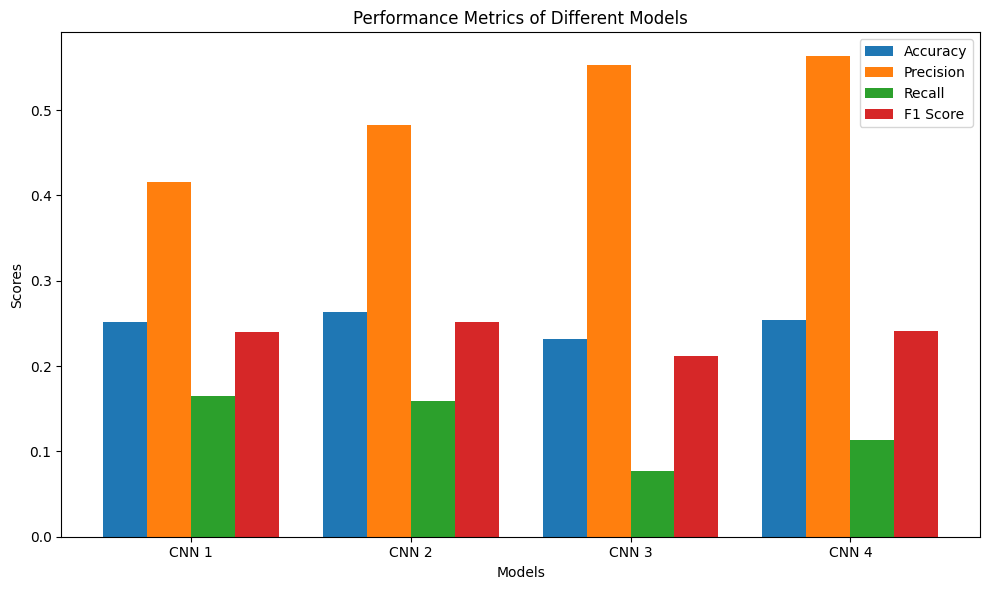

In [160]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual data)
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
accuracy = [0.85, 0.87, 0.86, 0.88]
precision = [0.83, 0.86, 0.85, 0.87]
recall = [0.84, 0.85, 0.86, 0.88]
f1_score = [0.83, 0.86, 0.85, 0.88]

model_names = [history1, history2, history3, history4]
accuracies = [np.mean(model.history['val_accuracy']) for model in model_names]
precisions = [np.mean(model.history['val_precision']) for model in model_names]
recalls = [np.mean(model.history['val_recall']) for model in model_names]
f1_scores = [np.mean(model.history['val_f1_score']) for model in model_names]

x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width*1.5, accuracies, width, label='Accuracy')
rects2 = ax.bar(x - width/2, precisions, width, label='Precision')
rects3 = ax.bar(x + width/2, recalls, width, label='Recall')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(['CNN 1', 'CNN 2', 'CNN 3', 'CNN 4'])
ax.legend()

fig.tight_layout()
plt.show()

#### Interpretation and Conclusion

Based on the results of the McNemar's test and the performance metrics:

  1) Model 4 consistently outperforms Models 1, 2, and 3:
    - Model 4 demonstrates high precision, accuracy, and F1 scores, making it the best-performing model overall.

  2) Statistical significance of error rates:
    - The McNemar's test results confirm that both Models 3 and 4 have significantly different (and better) error rates compared to Models 1 and 2, with very low p-values indicating strong statistical significance.

  3) Comparison of Models 3 and 4:
    - Models 3 and 4 show no significant difference in error rates, suggesting similar performance between these two models.
<br>
<br>


CNN 4 is the best performer overall. It has a balanced performance across all metrics and significantly outperforms other models. The McNemar's test results and performance metrics consistently support this conclusion, indicating that CNN 4 is the most reliable choice for practical applications in animal identification for feedlot management.









### Comparing the best performance Model 1 with a multi-layer perceptron (MLP)

In [162]:
# CREATE A BASELINE MLP WITH THREE LAYERS

# # since this is not binary, we should go ahead and one-hot encode the inputs
# y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
# y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30,
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','F1Score'])

history5 = mlp.fit(X_train_std, y_train_ohe,
        batch_size=32, epochs=75,
        shuffle=True, verbose=0,
        validation_data=(X_test_std,y_test_ohe),callbacks=[early_stopping])

mlp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_35 (Flatten)        (None, 12288)             0         
                                                                 
 dense_66 (Dense)            (None, 30)                368670    
                                                                 
 dense_67 (Dense)            (None, 15)                465       
                                                                 
 dense_68 (Dense)            (None, 90)                1440      
                                                                 
 activation_23 (Activation)  (None, 90)                0         
                                                                 
Total params: 370575 (1.41 MB)
Trainable params: 370575 (1.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


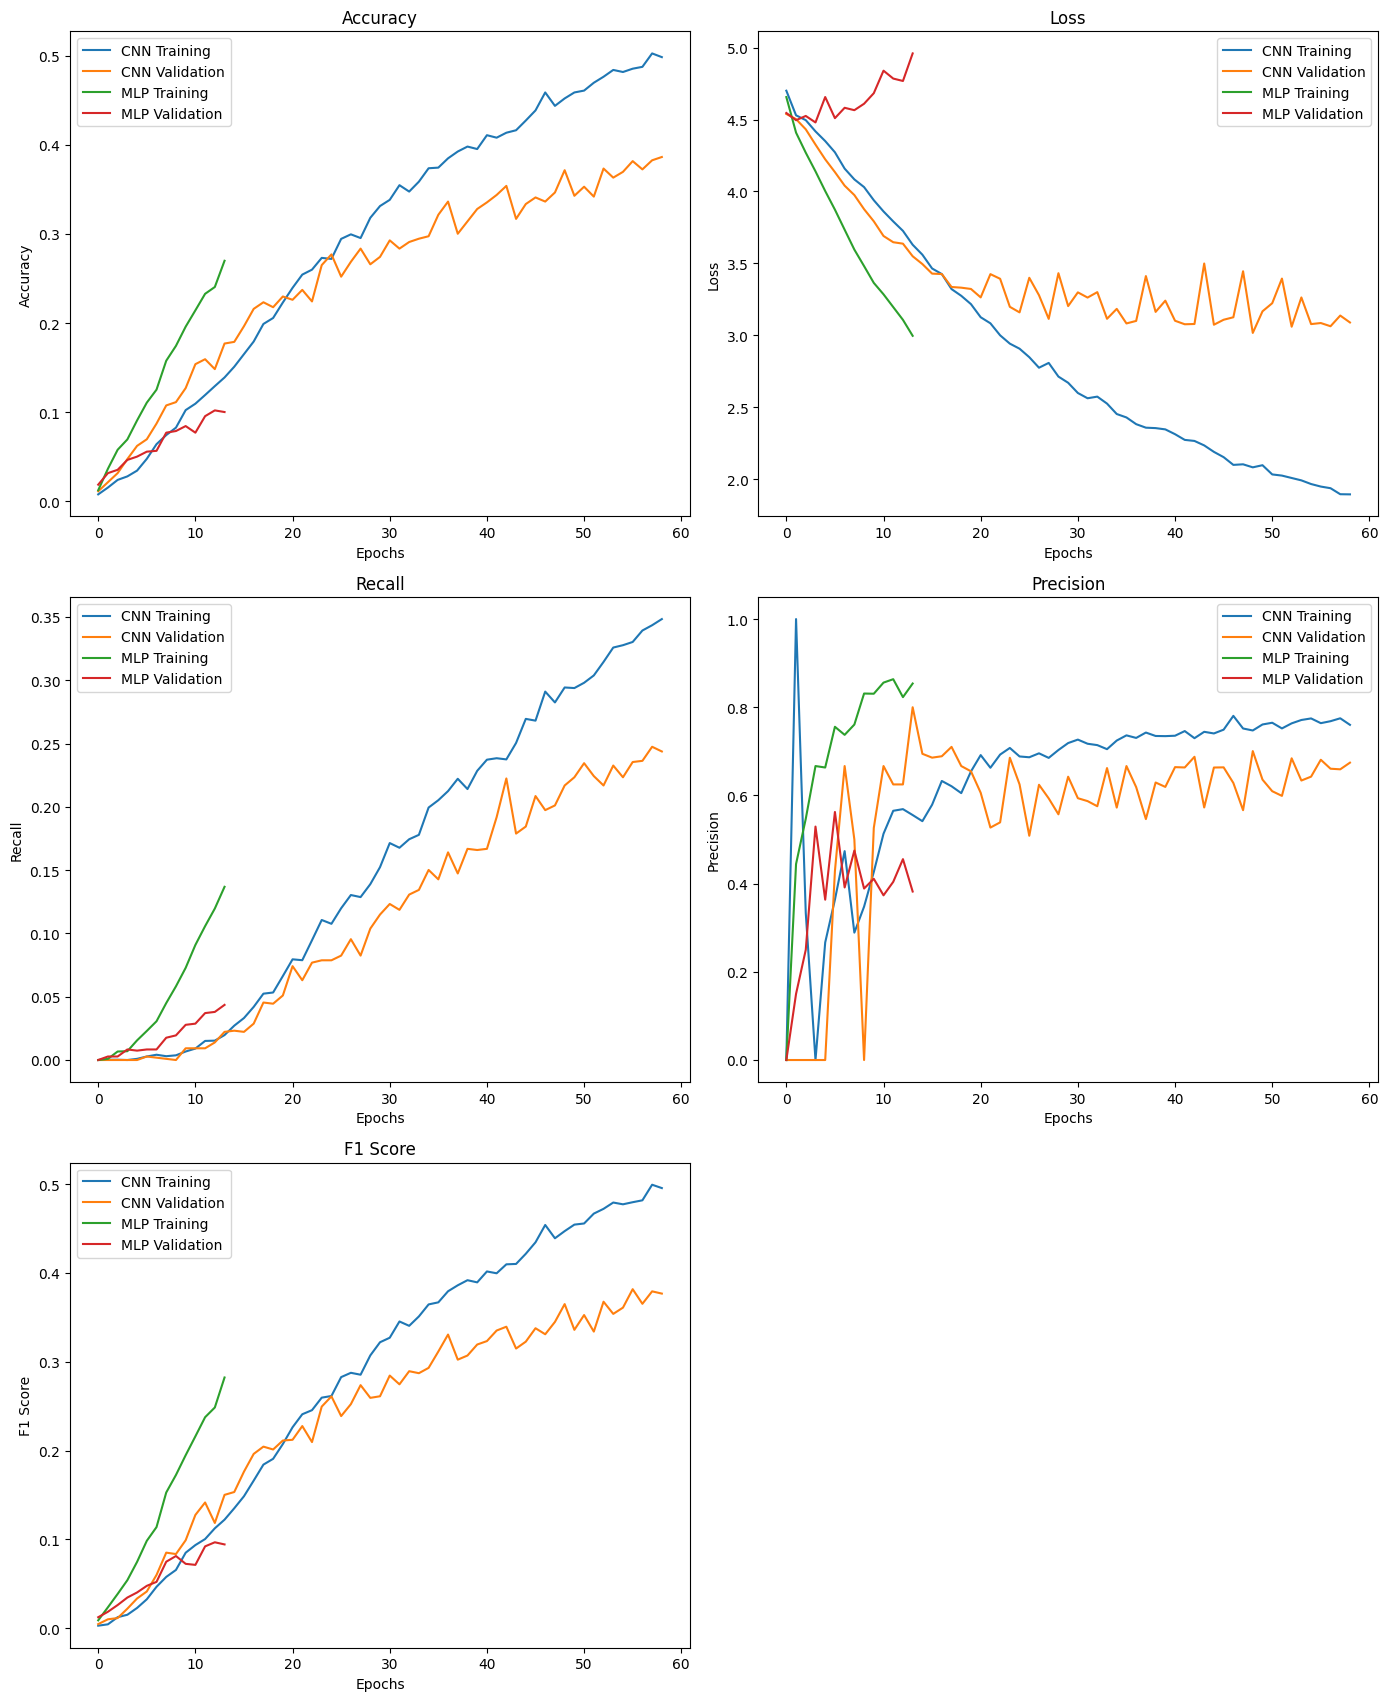

In [163]:
# Assuming history1 is for CNN and history2 is for MLP
history_cnn = history4  # Replace with actual CNN history
history_mlp = history5  # Replace with actual MLP history

# Helper function to plot metrics
def plot_metrics(metric, title, cnn_history, mlp_history):
    plt.plot(cnn_history.history[metric], label='CNN Training')
    plt.plot(cnn_history.history['val_' + metric], label='CNN Validation')
    plt.plot(mlp_history.history[metric], label='MLP Training')
    plt.plot(mlp_history.history['val_' + metric], label='MLP Validation')
    plt.ylabel(title)
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()

# Set the figure size to make the subplots larger
plt.figure(figsize=(14, 28))

# Accuracy Plot
plt.subplot(5, 2, 1)
plot_metrics('accuracy', 'Accuracy', history_cnn, history_mlp)

# Loss Plot
plt.subplot(5, 2, 2)
plot_metrics('loss', 'Loss', history_cnn, history_mlp)

# Recall Plot
plt.subplot(5, 2, 3)
plot_metrics('recall', 'Recall', history_cnn, history_mlp)

# Precision Plot
plt.subplot(5, 2, 4)
plot_metrics('precision', 'Precision', history_cnn, history_mlp)

# Compute F1 Score manually if not directly available in history
f1_cnn = [np.mean(history_cnn.history['f1_score'][i]) for i in range(len(history_cnn.history['f1_score']))]
val_f1_cnn = [np.mean(history_cnn.history['val_f1_score'][i]) for i in range(len(history_cnn.history['val_f1_score']))]

f1_mlp = [np.mean(history_mlp.history['f1_score'][i]) for i in range(len(history_mlp.history['f1_score']))]
val_f1_mlp = [np.mean(history_mlp.history['val_f1_score'][i]) for i in range(len(history_mlp.history['val_f1_score']))]

# F1 Score Plot
plt.subplot(5, 2, 5)
plt.plot(f1_cnn, label='CNN Training')
plt.plot(val_f1_cnn, label='CNN Validation')
plt.plot(f1_mlp, label='MLP Training')
plt.plot(val_f1_mlp, label='MLP Validation')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

#### McNemar

In [164]:
yhat_mlp = np.argmax(mlp.predict(X_test_std), axis=1)

print('The comparison between Model 1 and MLP with 95% confidence interval is as follows:')
table1 = mcnemar_table(y_target=y_test_int, y_model1=yhat_model4, y_model2=yhat_mlp)
chi12_, p12 = mcnemar(ary=table1, corrected=True)
print(table1)
print(f"chi² statistic: {chi12_}, p-value: {p12}")
if p12 > 0.05:
    print("Same proportions of errors (failed to reject Null Hypothesis--There isn't enough evidence to suggest that Models 4 and 5 (MLP) are different from each other )")
else:
        print('Different proportions of errors (reject Null Hypothesis)--There is enough evidence to suggest that Models 4 and 5 (MLP) are different from each other )')

34/34 [==============================] - 0s 2ms/step
The comparison between Model 1 and MLP with 95% confidence interval is as follows:
[[ 32 369]
 [ 18 660]]
chi² statistic: 316.5374677002584, p-value: 8.224857563030766e-71
Different proportions of errors (reject Null Hypothesis)--There is enough evidence to suggest that Models 4 and 5 (MLP) are different from each other )


#### ROC

34/34 [==============================] - 0s 2ms/step


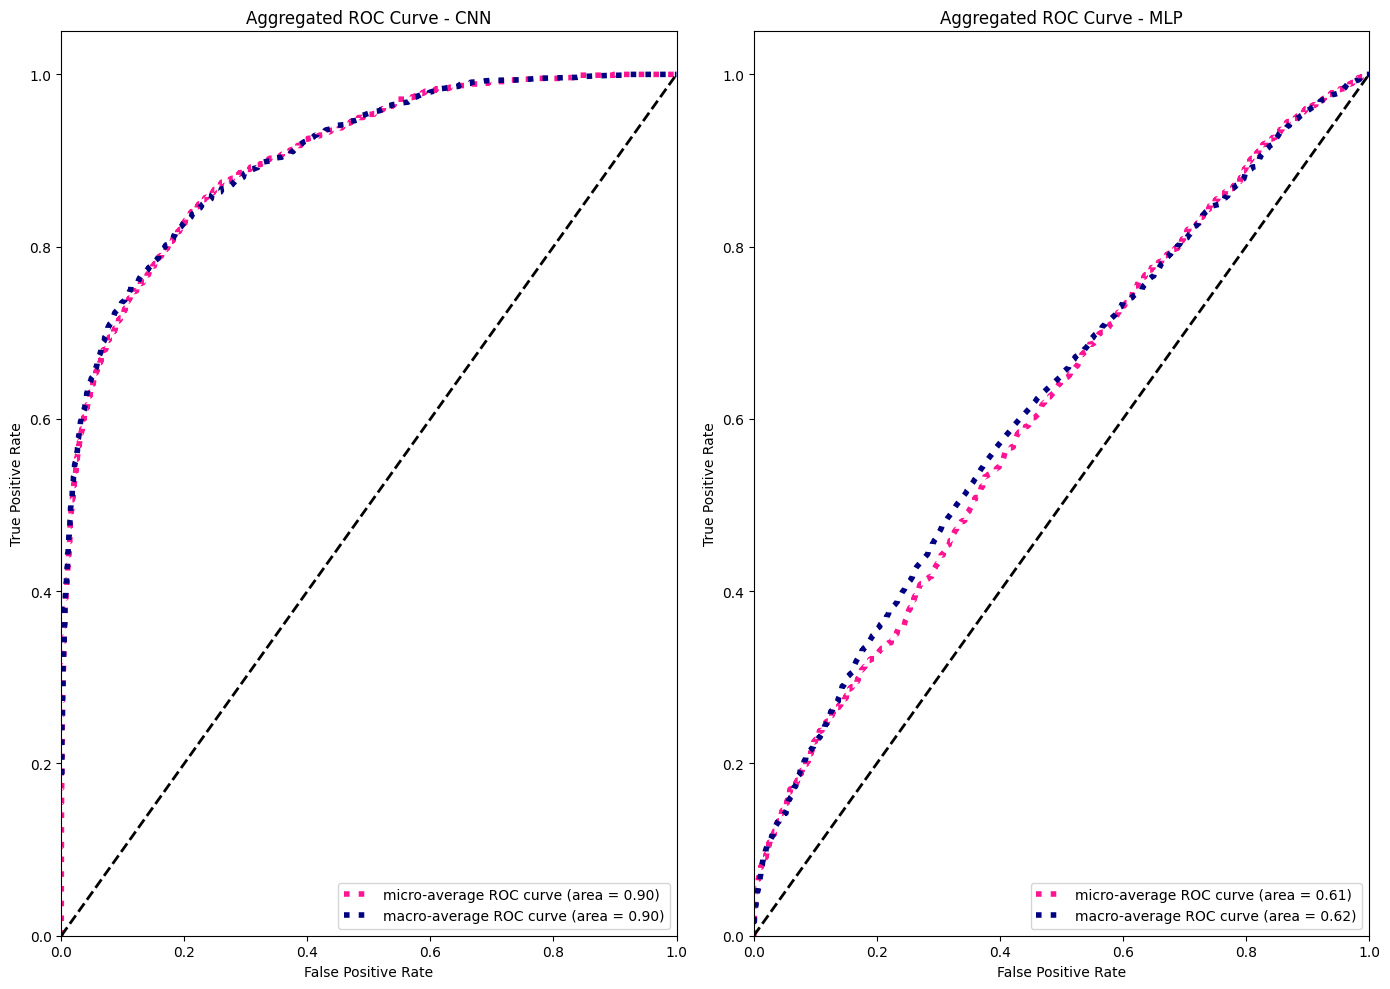

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

NUM_CLASSES = len(np.unique(y_test_int))  # Assuming y_test_int contains the true labels

# Convert labels to one-hot encoding if not already in that format
y_test_onehot = to_categorical(y_test_int, NUM_CLASSES)

# Get the predictions
y_pred_cnn = cnn4.predict(X_test_std)
y_pred_mlp = mlp.predict(X_test_std)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_mlp = dict()
tpr_mlp = dict()
roc_auc_mlp = dict()

for i in range(NUM_CLASSES):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_test_onehot[:, i], y_pred_cnn[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])
    fpr_mlp[i], tpr_mlp[i], _ = roc_curve(y_test_onehot[:, i], y_pred_mlp[:, i])
    roc_auc_mlp[i] = auc(fpr_mlp[i], tpr_mlp[i])

# Compute micro-average ROC curve and ROC area
fpr_cnn["micro"], tpr_cnn["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_cnn.ravel())
roc_auc_cnn["micro"] = auc(fpr_cnn["micro"], tpr_cnn["micro"])

fpr_mlp["micro"], tpr_mlp["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_mlp.ravel())
roc_auc_mlp["micro"] = auc(fpr_mlp["micro"], tpr_mlp["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr_cnn = np.unique(np.concatenate([fpr_cnn[i] for i in range(NUM_CLASSES)]))
mean_tpr_cnn = np.zeros_like(all_fpr_cnn)
all_fpr_mlp = np.unique(np.concatenate([fpr_mlp[i] for i in range(NUM_CLASSES)]))
mean_tpr_mlp = np.zeros_like(all_fpr_mlp)

for i in range(NUM_CLASSES):
    mean_tpr_cnn += np.interp(all_fpr_cnn, fpr_cnn[i], tpr_cnn[i])
    mean_tpr_mlp += np.interp(all_fpr_mlp, fpr_mlp[i], tpr_mlp[i])

mean_tpr_cnn /= NUM_CLASSES
roc_auc_cnn["macro"] = auc(all_fpr_cnn, mean_tpr_cnn)

mean_tpr_mlp /= NUM_CLASSES
roc_auc_mlp["macro"] = auc(all_fpr_mlp, mean_tpr_mlp)

plt.figure(figsize=(14, 10))

# Plot ROC curve for CNN
plt.subplot(1, 2, 1)
plt.plot(fpr_cnn["micro"], tpr_cnn["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_cnn["micro"]))
plt.plot(all_fpr_cnn, mean_tpr_cnn, color='navy', linestyle=':', linewidth=4,
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_cnn["macro"]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aggregated ROC Curve - CNN')
plt.legend(loc="lower right")

# Plot ROC curve for MLP
plt.subplot(1, 2, 2)
plt.plot(fpr_mlp["micro"], tpr_mlp["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_mlp["micro"]))
plt.plot(all_fpr_mlp, mean_tpr_mlp, color='navy', linestyle=':', linewidth=4,
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_mlp["macro"]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aggregated ROC Curve - MLP')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


The ROC curves and AUC values show a clear performance difference between the CNN 1 and the MLP (Multi-Layer Perceptron) models. The CNN's ROC curve, shown on the left, is much closer to the top-left corner, indicating superior performance. The micro-average and macro-average AUC values are 0.90, demonstrating a consistent and robust classification ability across all classes. The CNN model has a high true positive rate and a low false positive rate, confirming its effectiveness. On the other hand, the micro-average and macro-average AUC values for the MLP are approximately 0.61 and 0.62, respectively, indicating limited discrimination ability and variability in performance across different classes. The MLP model's true positive rate increases at a slower rate with a higher false positive rate, suggesting a higher propensity for misclassification.

## Exceptional Work

- Use transfer learning with pre-trained weights for your initial layers of your CNN. Compare the performance when using transfer learning to your best model from above in terms of classification performance.

In [166]:
%%time

# manipulated from Keras Documentation
#  https://keras.io/applications/
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

xcept_model = ResNet50(weights='imagenet')
xcept_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [167]:
# load only convolutional layers of ResNet50:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = X_train[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time
preds = res_no_top.predict(x)
print("prediction shape:", preds.shape,"\n")

X_train_res = preprocess_input(X_train_std)
X_test_res = preprocess_input(X_test_std)

# train on half the data, to save a few hours
X_train_res = res_no_top.predict(X_train_res)
X_test_res = res_no_top.predict(X_test_res)
print("Training Set shape:", X_train_res.shape,"\n")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
1/1 [==============================] - 0s 45ms/step
prediction shape: (1, 2, 2, 2048) 

34/34 [==============================] - 0s 11ms/step
Training Set shape: (4312, 2, 2, 2048) 



In [168]:
from keras.layers import SeparableConv2D
from keras.layers import Add, Flatten, Dense, Input
from keras.layers import average, concatenate
from keras.models import  Model
from keras.callbacks import EarlyStopping

# Early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# let's add a fully-connected layer
input_x = Input(shape=X_train_res[0].shape)
x = Flatten()(input_x)
x = Dense(256, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2, 2, 2048)]      0         
                                                                 
 flatten_36 (Flatten)        (None, 8192)              0         
                                                                 
 dense_69 (Dense)            (None, 256)               2097408   
                                                                 
 dense_70 (Dense)            (None, 90)                23130     
                                                                 
Total params: 2120538 (8.09 MB)
Trainable params: 2120538 (8.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [169]:
y_train_ohe_res = y_train_ohe[:X_train_res.shape[0]]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall','F1Score'])

history6 = model.fit(X_train_res, y_train_ohe_res,
          epochs=75, batch_size=64,verbose=0,
          validation_data=(X_test_res, y_test_ohe[:X_test_res.shape[0]]),callbacks=[early_stopping])

##### Performance Plots

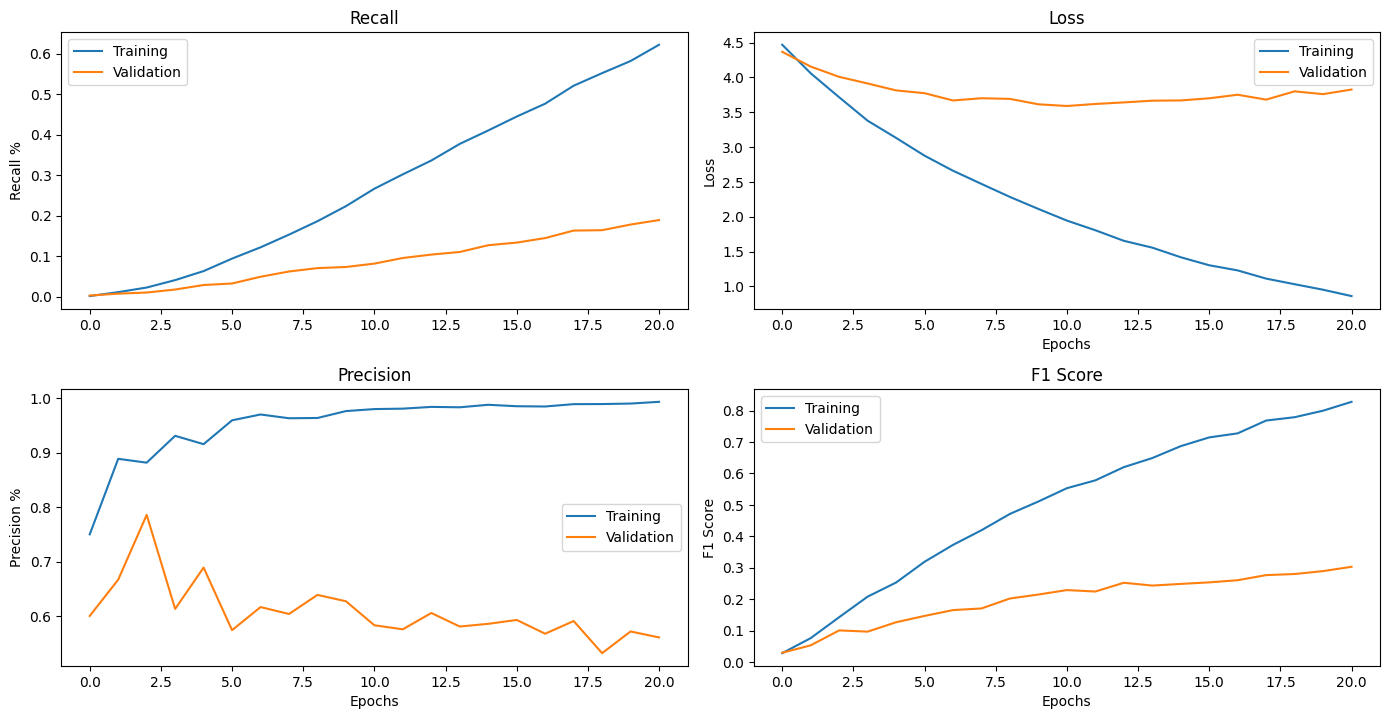

In [170]:
# Set the figure size to make the subplots larger
plt.figure(figsize=(14, 14))

# Recall Plot
plt.subplot(4,2,1)
plt.plot(history6.history['recall'], label='Training')
plt.plot(history6.history['val_recall'], label='Validation')
plt.ylabel('Recall %')
plt.title('Recall')
plt.legend()

# Loss Plot
plt.subplot(4,2,2)
plt.plot(history6.history['loss'], label='Training')
plt.plot(history6.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()

# Precision Plot
plt.subplot(4,2,3)
plt.plot(history6.history['precision'], label='Training')
plt.plot(history6.history['val_precision'], label='Validation')
plt.ylabel('Precision %')
plt.xlabel('Epochs')
plt.title('Precision')
plt.legend()

f1s_5 = [np.mean(history6.history['f1_score'][i]) for i in range(len(history6.history['f1_score']))]
val_f1s_5 = [np.mean(history6.history['val_f1_score'][i]) for i in range(len(history6.history['f1_score']))]
# F1 Score Plot
plt.subplot(4,2,4)
plt.plot(f1s_5, label='Training')
plt.plot(val_f1s_5, label='Validation')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

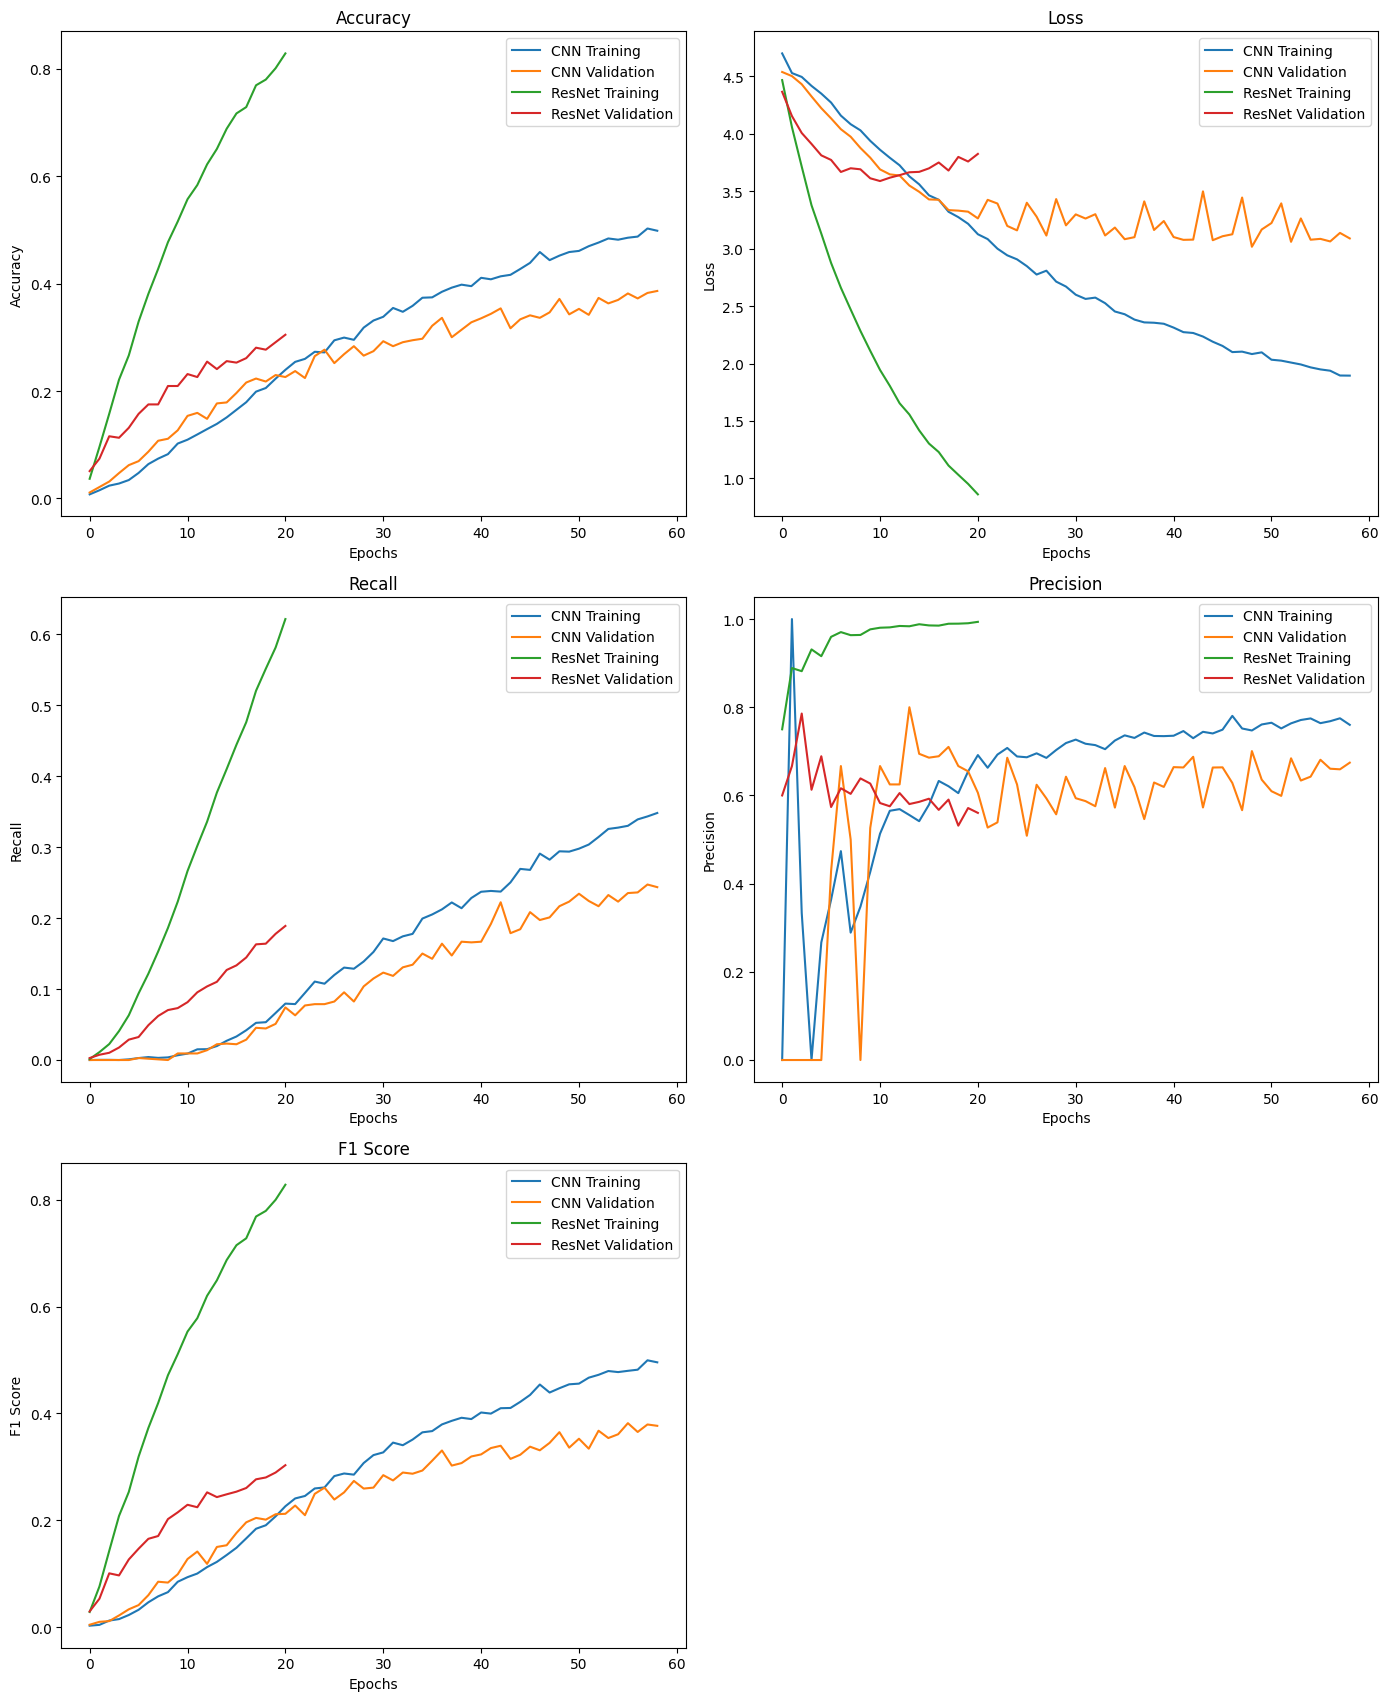

In [171]:
# Assuming history1 is for CNN and history2 is for MLP
history_cnn = history4  # Replace with actual CNN history
history_res = history6  # Replace with actual MLP history

# Helper function to plot metrics
def plot_metrics(metric, title, cnn_history, mlp_history):
    plt.plot(cnn_history.history[metric], label='CNN Training')
    plt.plot(cnn_history.history['val_' + metric], label='CNN Validation')
    plt.plot(mlp_history.history[metric], label='ResNet Training')
    plt.plot(mlp_history.history['val_' + metric], label='ResNet Validation')
    plt.ylabel(title)
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()

# Set the figure size to make the subplots larger
plt.figure(figsize=(14, 28))

# Accuracy Plot
plt.subplot(5, 2, 1)
plot_metrics('accuracy', 'Accuracy', history_cnn, history_res)

# Loss Plot
plt.subplot(5, 2, 2)
plot_metrics('loss', 'Loss', history_cnn, history_res)

# Recall Plot
plt.subplot(5, 2, 3)
plot_metrics('recall', 'Recall', history_cnn, history_res)

# Precision Plot
plt.subplot(5, 2, 4)
plot_metrics('precision', 'Precision', history_cnn, history_res)

# Compute F1 Score manually if not directly available in history
f1_cnn = [np.mean(history_cnn.history['f1_score'][i]) for i in range(len(history_cnn.history['f1_score']))]
val_f1_cnn = [np.mean(history_cnn.history['val_f1_score'][i]) for i in range(len(history_cnn.history['val_f1_score']))]

f1_res = [np.mean(history_res.history['f1_score'][i]) for i in range(len(history_res.history['f1_score']))]
val_f1_res = [np.mean(history_res.history['val_f1_score'][i]) for i in range(len(history_res.history['val_f1_score']))]

# F1 Score Plot
plt.subplot(5, 2, 5)
plt.plot(f1_cnn, label='CNN Training')
plt.plot(val_f1_cnn, label='CNN Validation')
plt.plot(f1_res, label='ResNet Training')
plt.plot(val_f1_res, label='ResNet Validation')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

##### ROC Curve

34/34 [==============================] - 0s 9ms/step


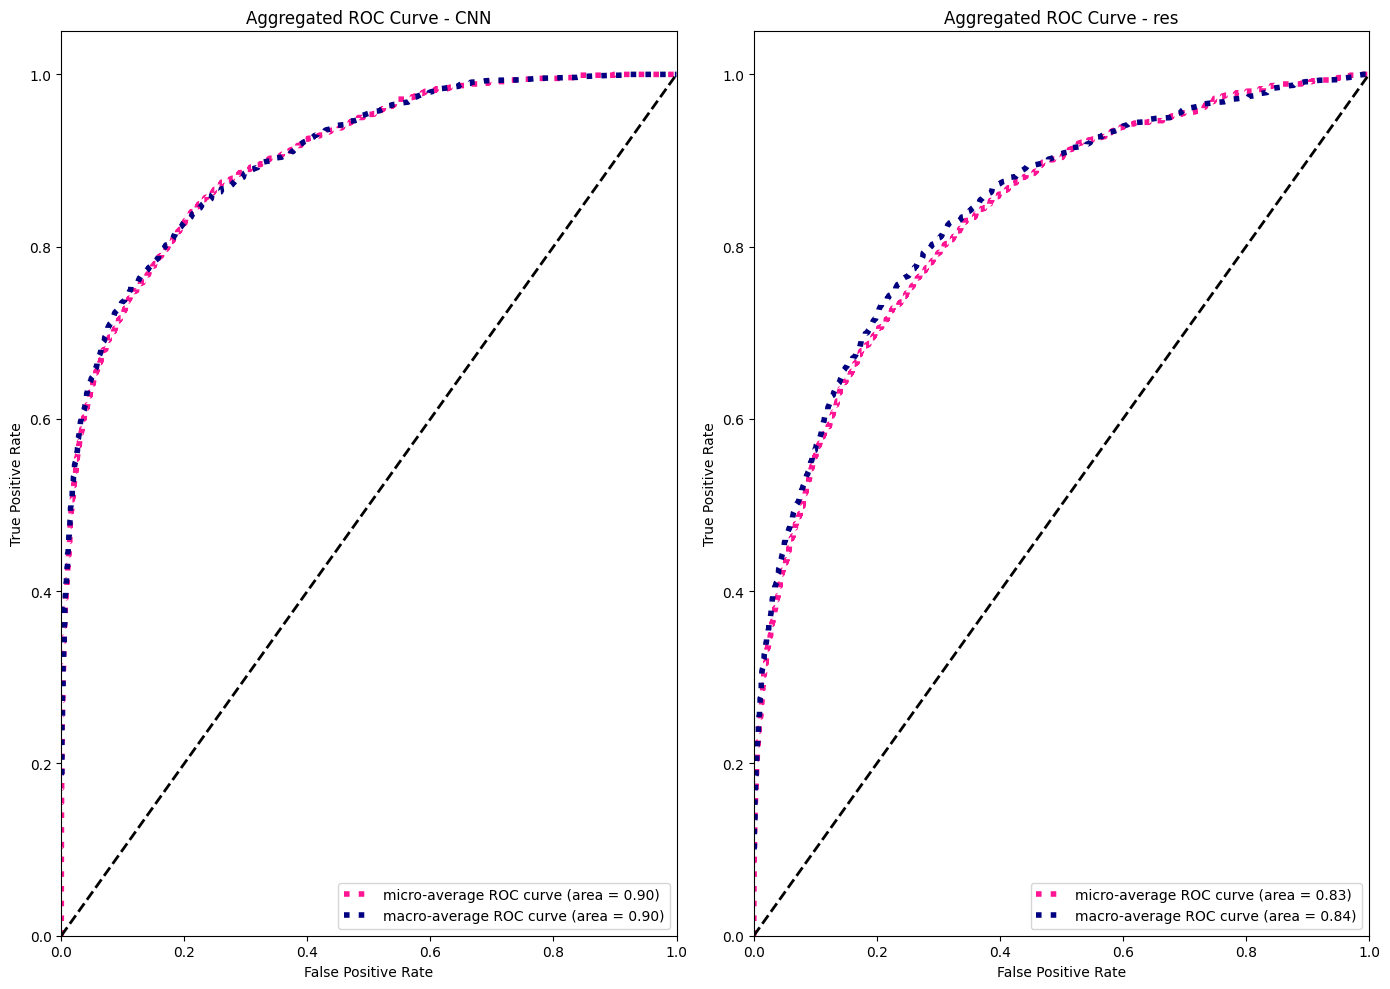

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

NUM_CLASSES = len(np.unique(y_test_int))  # Assuming y_test_int contains the true labels

# Convert labels to one-hot encoding if not already in that format
y_test_onehot = to_categorical(y_test_int, NUM_CLASSES)

# Get the predictions
# y_pred_cnn = cnn4.predict(X_test_std)
y_pred_res = model.predict(X_test_res)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_res = dict()
tpr_res = dict()
roc_auc_res = dict()

for i in range(NUM_CLASSES):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_test_onehot[:, i], y_pred_cnn[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])
    fpr_res[i], tpr_res[i], _ = roc_curve(y_test_onehot[:, i], y_pred_res[:, i])
    roc_auc_res[i] = auc(fpr_res[i], tpr_res[i])

# Compute micro-average ROC curve and ROC area
fpr_cnn["micro"], tpr_cnn["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_cnn.ravel())
roc_auc_cnn["micro"] = auc(fpr_cnn["micro"], tpr_cnn["micro"])

fpr_res["micro"], tpr_res["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_res.ravel())
roc_auc_res["micro"] = auc(fpr_res["micro"], tpr_res["micro"])

# Compute macro-average ROC curve and ROC area
fpr_cnn["macro"] = np.unique(np.concatenate([fpr_cnn[i] for i in range(NUM_CLASSES)]))
tpr_cnn["macro"] = np.zeros_like(fpr_cnn["macro"])
fpr_res["macro"] = np.unique(np.concatenate([fpr_res[i] for i in range(NUM_CLASSES)]))
tpr_res["macro"] = np.zeros_like(fpr_res["macro"])

for i in range(NUM_CLASSES):
    tpr_cnn["macro"] += np.interp(fpr_cnn["macro"], fpr_cnn[i], tpr_cnn[i])
    tpr_res["macro"] += np.interp(fpr_res["macro"], fpr_res[i], tpr_res[i])

tpr_cnn["macro"] /= NUM_CLASSES
roc_auc_cnn["macro"] = auc(fpr_cnn["macro"], tpr_cnn["macro"])

tpr_res["macro"] /= NUM_CLASSES
roc_auc_res["macro"] = auc(fpr_res["macro"], tpr_res["macro"])

plt.figure(figsize=(14, 10))

# Plot ROC curve for CNN
plt.subplot(1, 2, 1)
plt.plot(fpr_cnn["micro"], tpr_cnn["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_cnn["micro"]))
plt.plot(fpr_cnn["macro"], tpr_cnn["macro"], color='navy', linestyle=':', linewidth=4,
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_cnn["macro"]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aggregated ROC Curve - CNN')
plt.legend(loc="lower right")

# Plot ROC curve for res
plt.subplot(1, 2, 2)
plt.plot(fpr_res["micro"], tpr_res["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_res["micro"]))
plt.plot(fpr_res["macro"], tpr_res["macro"], color='navy', linestyle=':', linewidth=4,
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc_res["macro"]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aggregated ROC Curve - res')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


The ROC curves and AUC values compare the #4 CNN with ResNet models. The CNN's ROC curve on the left shows strong performance with micro-average and macro-average AUC values of 0.90, indicating effective classification abilities across all classes.

In contrast, the ResNet's ROC curve on the right, while still showing strong performance, has slightly lower AUC values of 0.83 for the micro-average and 0.84 for the macro-average. These values, although indicative of good performance are marginally lower than those of CNN. The ResNet model's ROC curve is slightly closer to the diagonal, suggesting a higher false positive rate than the CNN.

Overall, both models perform well, but CNN exhibits superior classification performance. The higher AUC values for CNN confirm its ability to distinguish between classes more accurately, making it the preferred model for the given task.








##### Reasons for ResNet's Performance:

The CNN performed better than ResNet in this task for a few reasons.

First, ResNet works best with large and complex datasets, so it may not be fully utilized with smaller or simpler datasets. Second, the complexity of ResNet can cause overfitting on smaller datasets, leading to worse performance on new data. Finally, limited training time and suboptimal hyperparameter settings can affect ResNet's performance compared to a well-tuned CNN.

Additionally, the CNN used in this comparison was carefully tuned with a deep understanding of the dataset, which allowed for optimized filter configurations that improved its performance.